In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as col
import scipy.optimize as opt

In [2]:
def euclidian_dist(a,b):
    return np.sqrt(np.square(a[0] - b[0]) + np.square(a[1] - b[1]))

In [3]:
def get_run_stats(pos_x, pos_y, t, occ_x, occ_y, nfil):
    for jj in range(nfil):
        #I apologize that this is so clunky but again, appending arrays to lists can be a fraught endeavour so we had  
        #to make this robust by making it very explicit.
        if jj == 0:
            occ = occ_x
            pos = pos_x
        else:
            occ = occ_y
            pos = pos_y
        
        npts = np.size(occ)
        #print(npts)
        run_len = []
        vels = []

        count = 0
        for ii in range(npts):
            #print(count)
            st = occ[ii]
            #print(st)

            if (st != 0 and count == 0):
                count += 1
                p1 = pos[ii]
                t1 = t[ii]
            elif (st != 0 and count != 0):
                count += 1
            elif (st == 0 and count != 0):
                dist = pos[ii] - p1
                dt = t[ii] - t1
                run_len.append(dist)
                vels.append(dist/dt)
                count = 0
            elif (st == 0 and count == 0):
                continue

        run_len = np.asarray(run_len)
        vels = np.asarray(vels)
        
        if run_len.size == 0:
            run_len = pos[-1] - pos[0]
            vels = (pos[-1] - pos[0])/(time[-1] - time[0])
            #not a great contingency, need to update this
        
        return np.mean(run_len), np.mean(vels)

In [4]:
def get_xlk(occ_x,occ_y):
    
    mult = occ_x*occ_y
    ratio = np.count_nonzero(mult)/np.size(mult)
    
    return ratio

In [5]:
def plot_state(xt, fil_indx, state, wb,n, title):
    
    for ii in range(n):
        plttr = np.zeros((2,2))
        
        wbind = uni_states_per_n*ii
        occ = np.sum(state[(wbind + 1):(wbind + uni_states_per_n)])
        
        if occ:
            plttr[0,:] = [wb[ii],0]
            plttr[1,:] = [xt[fil_indx],halfstep]
            
            plt.plot(plttr[:,0], plttr[:,1],'k-o')
    plt.plot(xt[fil_indx],halfstep,'ro', markersize = 10)
    plt.title(title)
    plt.xlim([0,0.05])
    plt.ylim([-0.01, 0.03])
    plt.hlines(0,0,0.2,colors = 'k',linewidth = 2.5)
    #plt.axis('equal')
    plt.show()

In [6]:
def generate_model(n, ATP):
    
    base_rates = np.array([a01,a10,a12,a21,a23,a32,a30*ATP]) 
    
    trans_per_n = 7
    uni_states_per_n = 4

    nstates = uni_states_per_n*n
    ntrans = trans_per_n*n
    
    
    a0 = np.zeros(ntrans)
    #a0 the rate matrix
    
    v = np.zeros((ntrans,nstates))
    #the matrix of transitions 
    
    s0 = np.zeros(nstates)
    s0[0:-1:uni_states_per_n] = 1
    #state matrix, starting everything in the unbound state
    
    
    #now we'll generate the matrix v which defines transitions between states
    count = 0
    for ii in range(n):
        ind = ii*trans_per_n
        a0[ind:ind+trans_per_n] = base_rates
        
        for jj in range(trans_per_n):

            blank = np.zeros(nstates)
            
            ubind = ii*uni_states_per_n
            #the index of the unbound state for head ii
            
            
            #this is specifically for a single topology
            #there is a more clever way of doing this but its still clunky for now
            if jj == 0:
                blank[ubind] = -1
                blank[ubind + 1] = 1
            elif jj == 1:
                blank[ubind] = 1
                blank[ubind + 1] = -1
            elif jj == 2:
                blank[ubind + 1] = -1
                blank[ubind + 2] = 1
            elif jj == 3:
                blank[ubind + 1] = 1
                blank[ubind + 2] = -1
            elif jj == 4:
                blank[ubind + 2] = -1
                blank[ubind + 3] = 1
            elif jj == 5:
                blank[ubind + 2] = 1
                blank[ubind + 3] = -1
            elif jj == 6:
                blank[ubind + 3] = -1
                blank[ubind + 0] = 1
            

            v[count,:] = blank

            count += 1
    
    bind_id = np.zeros(trans_per_n)
    bind_id[0] = 1

    unbind_id = np.zeros(trans_per_n)
    unbind_id[-1] = 1
    unbind_id[1] = 1
    
    return a0, v, s0, unbind_id, bind_id, uni_states_per_n, trans_per_n

In [7]:
def update_binding(ind, trans_per_n, nfil, fil, xt, s, wb, unbind_id, bind_id):
    
    #print('ind = ',ind)
    
    #check for binding
    indxxx = int(ind%trans_per_n)
    #print('index = ',indxxx)
    
    bind = bind_id[int(ind%trans_per_n)]
    unbind = unbind_id[int(ind%trans_per_n)]
    
    #print(bind,rebind,unbind)
    
    if bind:
        
        faliure = False
        hd_indx = int(np.floor(ind/trans_per_n))
        #print('ind = ',ind,'hd_indx = ',hd_indx)
        
        if nfil == 2:
            which = int(np.round(np.random.rand())) + 1
        elif nfil == 1:
            which = 1
        
        """
        This might be my most confusing variable choice. 'which' is the index I use for the n element vector 
        to distinguish between heads being bound to filament 1, 2 or unbound (0). 'fil index' is used to index
        the various two element quantities like xt and dx. I could have set unbound = 3 or something but this 
        seems somehow easier despite the gymnastics.
        """
        fil_indx = which - 1
        nbnd = np.size(fil[fil == which])
        olig_pos = xt[fil_indx]
        #print('xt = ',xt)
        num = np.random.rand()
        
        if (nbnd < max_hds_per_site and num < backward_prob):
            position = olig_pos - halfstep
        elif(nbnd < max_hds_per_site and num > backward_prob):
            position = olig_pos + halfstep
        else:
            faliure = True
            #print('failure')
        
        if not faliure:
            #print('binding position = ', position)
            wb[hd_indx] = position
            fil[hd_indx] = which
            
            
    #check for unbinding
    if unbind:
        #first calculate the index of the head that released
        hd_indx = int(np.floor(ind/trans_per_n))

        #now update that the head is unboun
        wb[hd_indx] = np.Inf
        fil[hd_indx] = 0
        #this value should never be used so it is set to infinity so that an error is thrown if it ever is

    
    return wb,fil

In [8]:
def update_positions(nfil,fil,s,wb,xt,n,uni_states_per_n):
    
    nbnd = np.zeros(2)
    dx = np.zeros(2)
    index_array = np.arange(n)
    
    for ff in range(nfil):
        
        indx = ff + 1
        #this is equivalent to 'which' above
        
        x = xt[ff]
        
        wbs = wb[fil == indx]
        hdlst = index_array[fil == indx]
        uni_wb = np.unique(wbs)
        nbnd[ff] = np.size(wbs)
        dist = x - wbs
        nsites = np.size(np.unique(dist))
        
        #if only one site is bound, we'll calculate the xt position
        if nsites == 1:
            
            nwb = 0
            npps = 0
            
            for hh in hdlst:

                nwb += np.sum(s[int(1 + uni_states_per_n*hh)])
                npps += 1 - np.sum(s[int(1 + uni_states_per_n*hh)])
                #we know that the head is bound so its either weakly bound or pps
            
            #print('nwb = ', nwb)
            #print('npps = ', npps)
            
            if nwb/(nwb + npps) > 0.5:
                xnew = uni_wb - halfstep
            else:
                xnew = uni_wb + halfstep
            
        else:
            xnew = xt[ff]
        
        dx[ff] = xnew - xt[ff]
        xt[ff] = xnew
        
        #instantaneous phosphate release
        if inst_phosphate:
            if dx[ff] > 0:
                wbnow = wb[fil == indx]
                hdsnow = index_array[fil == indx]
                signs = wbnow - xt[ff]
                behind = hdsnow[signs < 0]

                for oo in behind:
                    is_wb = s[int(1 + uni_states_per_n*oo)]

                    if is_wb:
                        s[int(1 + uni_states_per_n*oo)] = 0
                        s[int(2 + uni_states_per_n*oo)] = 1
                    else:
                        continue    
    
    return xt,dx,nbnd,s

In [9]:
def gillespie_step(s,a0,v,n,trans_per_n,uni_states_per_n,wb,xt,fil):
    
    #In order to disallow transitions from sates that are unoccipied, we'll multiply the base rate matrix a0 by the 
    #occupancy of each state.
    ntrans = trans_per_n*n
    xocc = np.zeros(ntrans)
    rear_pps = False
    for ii in range(int(n)):
        
        ind = ii*trans_per_n
        #index of the first transition for head ii
        
        indic = uni_states_per_n*ii
        #index of the unbound state for head ii
        

        #calculate which states are occupied, we dissallow transitions from unoccupied states
        blnk = np.zeros(trans_per_n)
        sm = np.sum(s[indic:indic+uni_states_per_n])
        blnk[0] = s[indic]
        blnk[1:3] = s[indic + 1]
        blnk[3:5] = s[indic + 2]
        blnk[5:] = s[indic + 3]
        #clunky and specific for this topology but it works
        
        #a little warning in case any cycle somehow gets multiple heads in it. This should be impossible but worth
        #the warning
        if sm > 1:
            print('danger!')
            print(s,blnk)
        
        
        #we also need to understand if any states are pre-powerstroke but strain prevented from stepping
        if coupled:
            
            which = fil[ii]

            if (which > 0 and (s[indic + 2] or s[indic + 1])):

                wbs = wb[fil == which]
                uni_wb = np.unique(wbs)
                nsites = np.size(np.unique(uni_wb))

                sign = np.sign(wb[ii] - xt[int(which - 1)])

                if (sign == 1 and nsites > 1):
                    blnk[4] = blnk[4]*how_much_couple
                    #print(blnk)
            
            if (which > 0 and s[indic + 3]):
                
                wbs = wb[fil == which]
                uni_wb = np.unique(wbs)
                nsites = np.size(np.unique(uni_wb))

                sign = np.sign(wb[ii] - xt[int(which - 1)])
                
                if sign < 0:
                    rear_pps = True
                
                """
                if nsites == 1:
                    
                    blnk[6] = blnk[6]*release_slow_down
                """
            #these are the adjustments to the base rates
        xocc[ind:ind+trans_per_n] = blnk

    if rear_pps:
        xocc[0:-1:trans_per_n] = xocc[0:-1:trans_per_n]*binding_increase
    
    a = a0*xocc 
    #scaling the base rates by the occupancies
 

    #the actual gillespie step
    at = np.sum(a)
    r1 = np.random.rand()
    r2 = np.random.rand()

    tau = 1/at*np.log(1/r1)

    numel = np.size(a)
    thresh = at*r2
    for ii in range(numel):
        jj = ii + 1
        aj = np.sum(a[:jj])
        if aj < thresh:
            continue
        else:
            j = ii
            dx = v[j,:]
            break
    
    dt = tau
    return dx,dt,j

In [10]:
def get_trajectory(n,nfil,tfinal,ATP):
    
    count = 0

    a0, v, s0, unbind_id, bind_id, uni_states_per_n, trans_per_n = generate_model(n,ATP)

    state = []
    time = []
    disp = []
    pos_x = []
    pos_y = []
    occ_x = []
    occ_y = []
    change_x = []
    change_y = []
    #bind_state = []

    nstates = uni_states_per_n*n 
    ntrans = trans_per_n*n
    
    t = 0
    s = s0
    #print(s0)
    xt = np.zeros(2)

    wb = np.zeros(n)
    fil = np.zeros(n)
    

    while t < tfinal:

        dx = np.zeros(2)
        nbnd = np.zeros(2)
        #Gillespie step
        ds,dt,ind = gillespie_step(s,a0,v,n, trans_per_n, uni_states_per_n,wb,xt,fil)

        #update state and time
        s = s + ds
        t = t + dt
        
        
        #attempt a binding event, will only occur if the correct transition has occured
        wb,fil = update_binding(ind, trans_per_n, nfil, fil, xt, s, wb, unbind_id, bind_id)
        
        #relax any mechanical strains in the system 
        xt,dx,nbnd,s = update_positions(nfil,fil,s,wb,xt,n,uni_states_per_n)
        
        #keep track of displacement events. Can only occur if crosslinked
        if (nbnd[0] != 0 and nbnd[1] != 0):
            disp.append(np.sum(dx))
            #print('vel = ', np.sum(dx)/dt)
        else:
            disp.append(0)
        
        
        #plot if we're feeling like it
        if do_plot:
            plot_state(xt,0,s,wb,n)
            
            
            
        state.append(s)
        time.append(t)
        change_x.append(dx[0])
        change_y.append(dx[1])
        pos_x.append(xt[0])
        pos_y.append(xt[1])
        occ_x.append(nbnd[0])
        occ_y.append(nbnd[1])
        #these are very explicit becasue it turns out that appending arrays to lists is a fraught
        #endeavour in python

        count += 1

    state = np.asarray(state)
    time = np.asarray(time)
    disp = np.asarray(disp)
    pos_x = np.asarray(pos_x)
    pos_y = np.asarray(pos_y)
    occ_x = np.asarray(occ_x)
    occ_y = np.asarray(occ_y)
    change_x = np.asarray(change_x)
    change_y = np.asarray(change_y)
    
    #print(occ_x)
    
    return state, time, disp, pos_x, pos_y, occ_x, occ_y, change_x,change_y

In [11]:
"""
#base rates
a01 = 9e1
a10 = 5e0
a12 = 5e2
a21 = 1e1
a23 = 3e3
a32 = 1e1
a34 = 1e1
a43 = 5e2
a40 = 4e2 
"""

#good base rates

a01 = 9e0
a10 = 4e0
a12 = 3e3
a21 = 1e1
a23 = 3e3
a32 = 1e1
a30 = 1e0 


trans_per_n = 7
uni_states_per_n = 4

bind_id = np.zeros(trans_per_n)
bind_id[0] = 1


unbind_id = np.zeros(trans_per_n)
unbind_id[-3] = 1
unbind_id[1] = 1


In [12]:
halfstep = 0.01
max_hds_per_site = 4
date = '070822_coupled'
save = True
tfinal = 30
backward_prob = 0.1
inst_phosphate = False
rebind = False
coupled = True
how_much_couple = 2.5e-2
binding_increase = 2.5e1

In [13]:
"""Time to do some very simple tests"""

'Time to do some very simple tests'

average run length = 0.31700000000002143 um
average velocity = 5.697834815458981 um/s


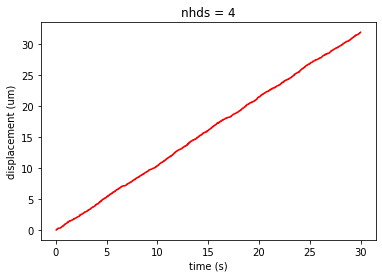

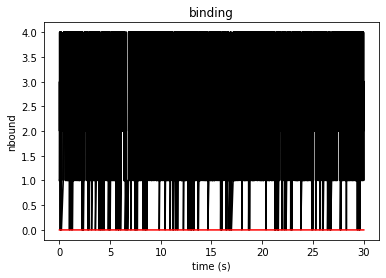

In [14]:
#test run to make sure things are working
do_plot = False
save_plot = False
ATP = 100
hds = 4
nfil = 1
#tfinal = 30

state, time, disp, pos_x, pos_y, occ_x, occ_y, change_x, change_y = get_trajectory(hds,nfil,tfinal,ATP)
rlen, vel = get_run_stats(pos_x, pos_y, time, occ_x, occ_y, nfil)

#print(xt)

print('average run length = %s um' %rlen)
print('average velocity = %s um/s' %vel)

#whole trajectory
plt.plot(time,pos_x,'r')
#plt.plot(time,pos_y,'k')
plt.xlabel('time (s)')
plt.ylabel('displacement (um)')
plt.title('nhds = %s' %hds)
plt.show()

plt.plot(time,occ_x,'k')
plt.plot(time,occ_y,'r')
plt.xlabel('time (s)')
plt.ylabel('nbound')
plt.title('binding')
plt.show()

#plt.hist(change_x[change_x != 0], bins = 80)
#plt.title('step distribution n = %s heads' %hds)
#plt.show()

#print('average step size = ', np.mean(change_x))

In [15]:
#big run coming next!

In [17]:
#single filament phase space
ntrials = 5
atps = np.logspace(-1,3,15)
nhds = np.linspace(2,10,9)
#nhds = 6
do_plot = False
save_plot = False
nfil = 1
#tfinal = 30

run_len = np.zeros((np.size(atps),np.size(nhds)))
run_err = np.zeros((np.size(atps),np.size(nhds)))

velocity = np.zeros((np.size(atps),np.size(nhds)))
vel_err = np.zeros((np.size(atps),np.size(nhds)))

for aa in range(np.size(atps)):
    ATP = atps[aa]
    for nn in range(np.size(nhds)):
        
        n = int(nhds[nn])
        
        temp_vel = np.zeros(ntrials)
        temp_dur = np.zeros(ntrials)
        temp_rlen = np.zeros(ntrials)
        for ii in range(ntrials):
            state, time, disp, pos_x, pos_y, occ_x, occ_y, change_x, change_y = get_trajectory(n,nfil,tfinal,ATP)
            
            """
            plt.plot(time,pos_x,'r')
            plt.xlabel('time (s)')
            plt.ylabel('displacement (um)')
            plt.title('nhds = %s' %n)
            plt.show()
            """
            
            rlen, vel = get_run_stats(pos_x, pos_y, time, occ_x, occ_y, nfil)
            temp_vel[ii] = vel
            temp_rlen[ii] = rlen
            #temp_dur[ii] = np.count_nonzero(bind_state)/np.size(bind_state)
        
        run_len[aa,nn] = np.mean(temp_rlen)
        run_err[aa,nn] = np.std(temp_rlen)
        
        velocity[aa,nn] = np.mean(temp_vel)
        vel_err[aa,nn] = np.std(temp_vel)
    
    print(aa,nn)

0 8
1 8
2 8
3 8
4 8
5 8
6 8
7 8
8 8
9 8
10 8
11 8
12 8
13 8
14 8


In [18]:
if save:
    root = '/project2/gardel/steven/arrays/%s_2_state_step_motor_controls_' %date
    np.savetxt(root + 'velocity.txt',velocity)
    np.savetxt(root + 'vel_err.txt',vel_err)
    np.savetxt(root + 'run_len.txt',run_len)
    np.savetxt(root + 'run_err.txt',run_err)
    np.savetxt(root + 'atps.txt',atps)
    np.savetxt(root + 'nhds.txt',nhds)

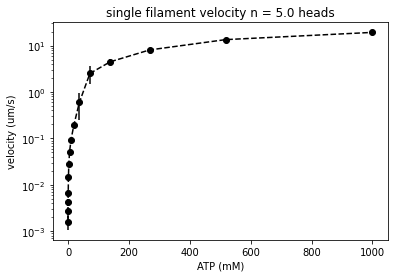

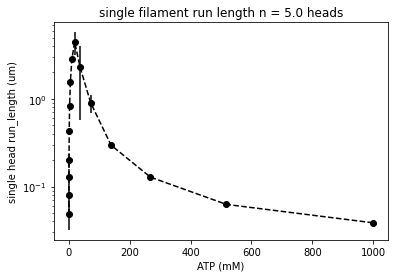

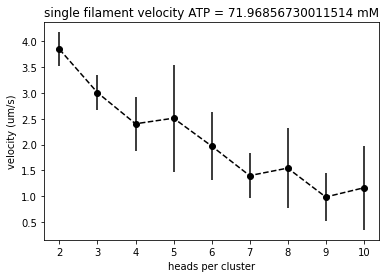

In [19]:
slc = 3

plt.errorbar(atps, velocity[:,slc], vel_err[:,slc], fmt = 'k--o')
plt.xlabel('ATP (mM)')
plt.ylabel('velocity (um/s)')
plt.gca().set_yscale('log')
plt.title('single filament velocity n = %s heads' %nhds[slc])
plt.show()

plt.errorbar(atps, run_len[:,slc], run_err[:,slc], fmt = 'k--o')
plt.xlabel('ATP (mM)')
plt.ylabel('single head run_length (um)')
plt.gca().set_yscale('log')
plt.title('single filament run length n = %s heads' %nhds[slc])
plt.show()

slc2 = 10
plt.errorbar(nhds[:], velocity[slc2,:], vel_err[slc2,:], fmt = 'k--o')
plt.xlabel('heads per cluster')
plt.ylabel('velocity (um/s)')
#plt.gca().set_xscale('log')
plt.title('single filament velocity ATP = %s mM' %atps[slc2])
plt.show()

In [20]:
#displacement phase space
ntrials = 5
atps = np.logspace(0,4,25)
nhds = np.linspace(2,10,9)
#nhds = 6
do_plot = False
save_plot = False
nfil = 2
#tfinal = 30

run_len = np.zeros((np.size(atps),np.size(nhds)))
run_err = np.zeros((np.size(atps),np.size(nhds)))

velocity = np.zeros((np.size(atps),np.size(nhds)))
vel_err = np.zeros((np.size(atps),np.size(nhds)))

displacement = np.zeros((np.size(atps),np.size(nhds)))
disp_err = np.zeros((np.size(atps),np.size(nhds)))

xlk = np.zeros((np.size(atps),np.size(nhds)))
xlk_err = np.zeros((np.size(atps),np.size(nhds)))


for aa in range(np.size(atps)):
    ATP = atps[aa]
    for nn in range(np.size(nhds)):
        
        n = int(nhds[nn])
        
        temp_vel = np.zeros(ntrials)
        temp_dur = np.zeros(ntrials)
        temp_rlen = np.zeros(ntrials)
        temp_disp = np.zeros(ntrials)
        temp_xlk = np.zeros(ntrials)
        for ii in range(ntrials):
            state, time, disp, pos_x, pos_y, occ_x, occ_y, change_x, change_y = get_trajectory(n,nfil,tfinal,ATP)
            
            """
            plt.plot(time,pos_x,'r')
            plt.xlabel('time (s)')
            plt.ylabel('displacement (um)')
            plt.title('nhds = %s' %n)
            plt.show()
            """
            
            rlen, vel = get_run_stats(pos_x, pos_y, time, occ_x, occ_y, nfil)
            temp_vel[ii] = vel
            temp_rlen[ii] = rlen
            #temp_dur[ii] = np.count_nonzero(bind_state)/np.size(bind_state)
            
            temp_disp[ii] = np.sum(disp)
            temp_xlk[ii] = get_xlk(occ_x,occ_y)
            
        run_len[aa,nn] = np.mean(temp_rlen)
        run_err[aa,nn] = np.std(temp_rlen)
        
        velocity[aa,nn] = np.mean(temp_vel)
        vel_err[aa,nn] = np.std(temp_vel)
        
        displacement[aa,nn] = np.mean(temp_disp)
        disp_err[aa,nn] = np.std(temp_disp)
        
        xlk[aa,nn] = np.mean(temp_xlk)
        xlk_err[aa,nn] = np.std(temp_xlk)
    
    print(aa,nn)

0 8
1 8
2 8
3 8
4 8
5 8
6 8
7 8
8 8
9 8
10 8
11 8
12 8
13 8
14 8
15 8
16 8
17 8
18 8
19 8
20 8
21 8
22 8
23 8
24 8


In [21]:
if save:
    root = '/project2/gardel/steven/arrays/%s_2_state_step_motor_run_' %date
    np.savetxt(root + 'displacement.txt',displacement)
    np.savetxt(root + 'disp_err.txt',disp_err)
    np.savetxt(root + 'xlk.txt',xlk)
    np.savetxt(root + 'xlk_err.txt',xlk_err)
    np.savetxt(root + 'atps.txt',atps)
    np.savetxt(root + 'nhds.txt',nhds)

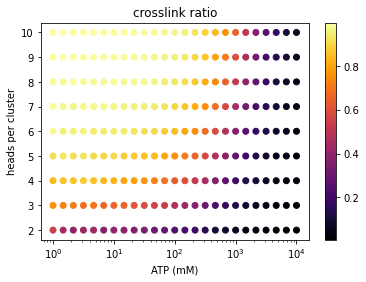

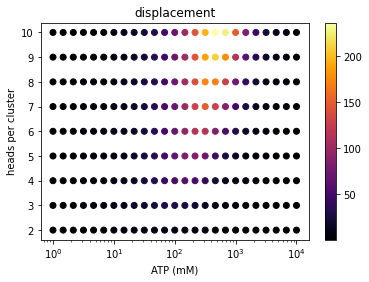

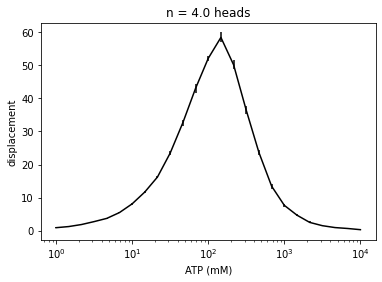

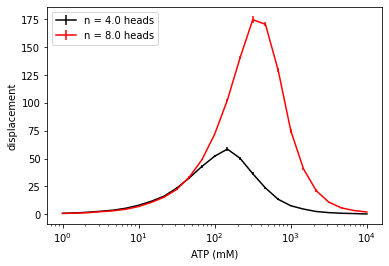

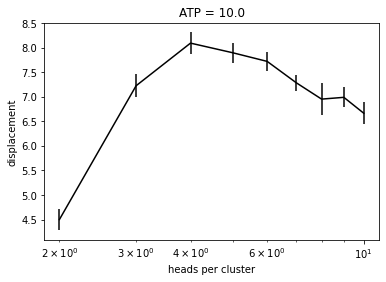

In [22]:
#xlking phase space
space1, space2 = np.meshgrid(atps,nhds)
#print(np.shape(space1),np.shape(xlk))
plt.scatter(space1.flatten(),space2.flatten(),c = xlk.transpose().flatten(),cmap = 'inferno')
plt.gca().set_xscale('log')
plt.colorbar()
plt.xlabel('ATP (mM)')
plt.ylabel('heads per cluster')
plt.title('crosslink ratio')
plt.show()

#displacement phase space
space1, space2 = np.meshgrid(atps,nhds)
#print(np.shape(space1),np.shape(xlk))
plt.scatter(space1.flatten(),space2.flatten(),c = displacement.transpose().flatten(),cmap = 'inferno')#,\
            #norm=col.LogNorm(),)
plt.gca().set_xscale('log')
plt.colorbar()
plt.xlabel('ATP (mM)')
plt.ylabel('heads per cluster')
plt.title('displacement')
plt.show()

#single slice in ATP
slc = 2
slc2 = 6
plt.errorbar(atps,displacement[:,slc],disp_err[:,slc], fmt = 'k')
plt.gca().set_xscale('log')
#plt.gca().set_yscale('log')
plt.xlabel('ATP (mM)')
plt.ylabel('displacement')
plt.title('n = %s heads' %nhds[slc])
plt.show()

plt.errorbar(atps,displacement[:,slc],disp_err[:,slc], fmt = 'k', label = 'n = %s heads' %nhds[slc])
plt.errorbar(atps,displacement[:,slc2],disp_err[:,slc2], fmt = 'r', label = 'n = %s heads' %nhds[slc2])
plt.gca().set_xscale('log')
plt.xlabel('ATP (mM)')
plt.ylabel('displacement')
plt.legend()
#plt.title('n = %s heads' %nhds[2])
plt.show()

#single slice in cluster_size
slc = 6
plt.errorbar(nhds,displacement[slc,:],disp_err[slc,:], fmt = 'k')
plt.gca().set_xscale('log')
#plt.gca().set_yscale('log')
plt.xlabel('heads per cluster')
plt.ylabel('displacement')
plt.title('ATP = %s' %atps[slc])
plt.show()
